In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM
from policy.networks import MLP#,MLP2

2024-11-26 18:24:14.360929: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [4]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

In [5]:
@eqx.filter_jit
def reset_env(env,rng):
    obs, _ = env.reset(env.env_properties, rng)  #
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

In [6]:
@eqx.filter_jit
def motor_env_dat_gen_sin(env,reset_env, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset_env(env,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset_env(env,subkey)  
    return init_obs, ref_obs, rng

In [7]:
@eqx.filter_jit
def featurize(obs,ref_obs, featurize_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])#jnp.concatenate([obs[0:2],obs[6:8],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])
    featurize_state=jnp.clip(featurize_state + ref_obs[0:2]-obs[0:2],min=-1,max=1) * (jnp.sign(0.01-jnp.sum((ref_obs[0:2]-obs[0:2])**2))*0.5+0.5)
    return feat_obs,featurize_state

In [8]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,4:6])**2,axis=1))#be aware of idx if changing featurize
    return loss

In [9]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    loss=jnp.array([0])
    return loss

In [10]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([8,64,64,64,2],key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

In [11]:
data_batch_size=100
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=1000,
    horizon_length=50,
    reset_env=reset_env,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [12]:
import matplotlib.pyplot as plt
from utils.evaluation import steps_eval

100%|██████████| 1000/1000 [01:09<00:00, 14.46it/s]


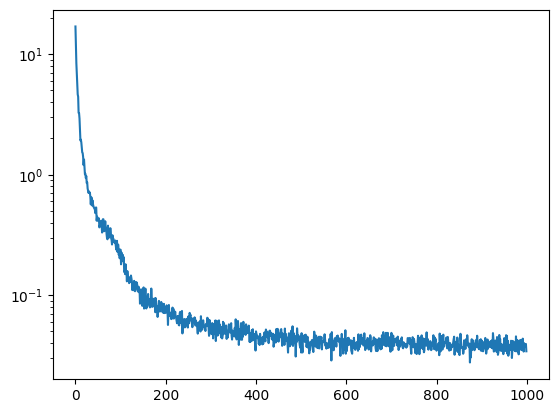

In [13]:
fin_policy2,fin_opt_state2,fin_keys2,losses2=trainer.fit_non_jit(policy,motor_env,keys,opt_state)
plt.plot(losses2)
plt.yscale('log')

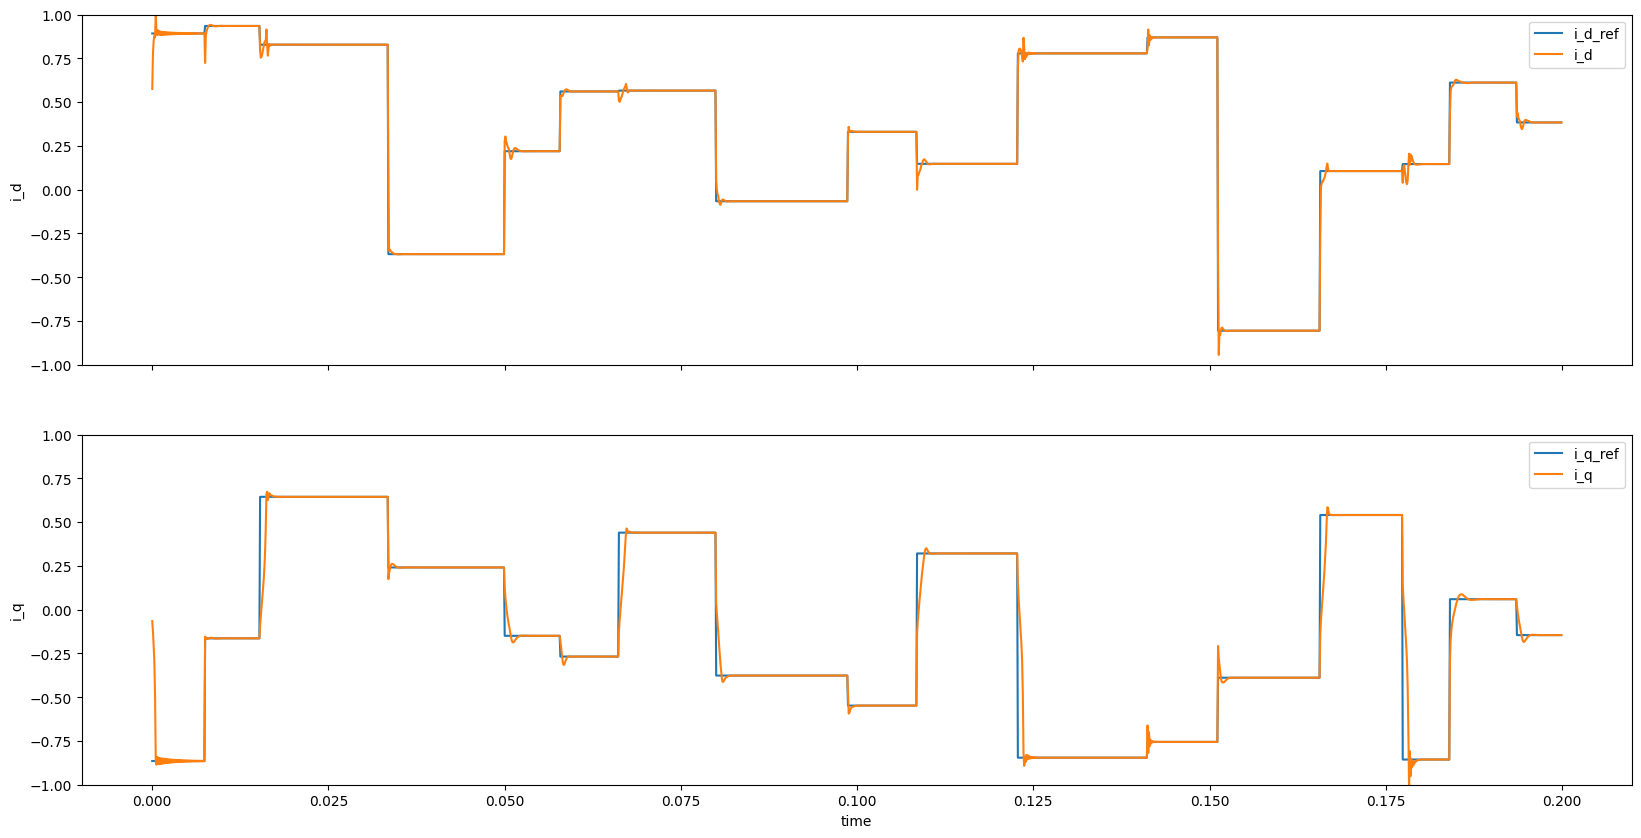

In [14]:
obs,obs2,acts=steps_eval(motor_env,reset_env,fin_policy2,featurize,jax.random.PRNGKey(765),2000)

## Model Learning

In [15]:
from utils.interactions import rollout_traj_env_policy
from models.model_training import ModelTrainer
from models.models import NeuralEulerODE

In [16]:
@eqx.filter_jit
def reset_env(env,rng):
    obs, _ = env.reset(env.env_properties, rng)  #
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

In [17]:
def featurize_node(obs):
    return obs[:2]

In [18]:
from utils.signals import steps_ref_traj

In [19]:
def data_gen_single(rng, sequence_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset_env(motor_env,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset_env(motor_env,subkey)
    obs,acts=rollout_traj_env_policy(fin_policy2, init_obs, ref_obs, sequence_len, motor_env, featurize)
    return obs,acts,rng
# use fin_policy

In [20]:
rng=jax.random.PRNGKey(24)
ref_len=400
rng, subkey = jax.random.split(rng)
obs_ref_val = steps_ref_traj(motor_env, reset_env, subkey, ref_len, step_lens=[20,50])
rng, subkey = jax.random.split(rng)
init_obs_val = reset_env(motor_env,subkey)
obs_val, acts_val = rollout_traj_env_policy(fin_policy2, init_obs_val, obs_ref_val, ref_len, motor_env, featurize)
@eqx.filter_jit
def val_data_gen_single(rng, sequence_len):
    obs=obs_val
    acts=acts_val
    return obs,acts,rng

In [21]:
jax_key = jax.random.PRNGKey(4)
node=NeuralEulerODE([4,128,128,128,2],key=jax_key)
optimizer_node = optax.adam(5e-4)
opt_state = optimizer_node.init(node)

In [22]:
batch_size=100
mtrainer=ModelTrainer(
    train_steps=50_000,
    batch_size=batch_size,
    sequence_len=25,
    featurize=featurize_node,
    train_data_gen_sin=data_gen_single,
    val_data_gen_sin= val_data_gen_single,
    model_optimizer=optimizer_node,
    tau= motor_env.tau
    )
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(batch_size,)))

  0%|          | 0/50000 [00:00<?, ?it/s]

  4%|▍         | 1996/50000 [00:38<11:57, 66.89it/s] 

Current val_loss: 0.045560934


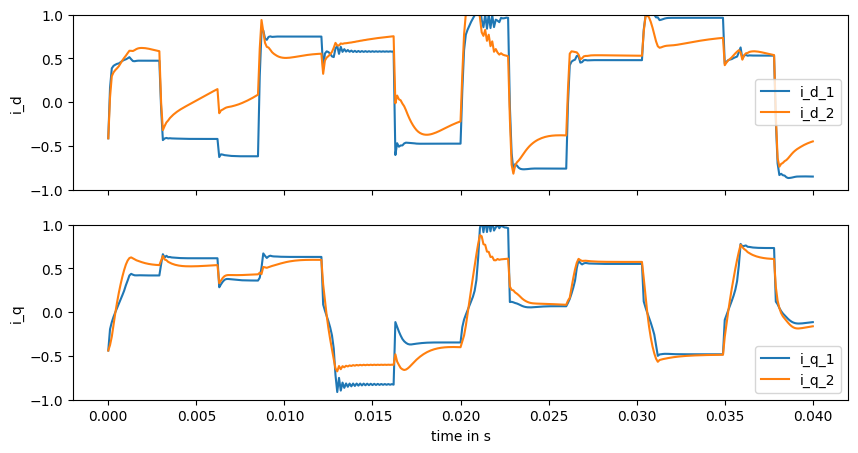

  8%|▊         | 3998/50000 [01:10<11:27, 66.93it/s]  

Current val_loss: 0.031374954


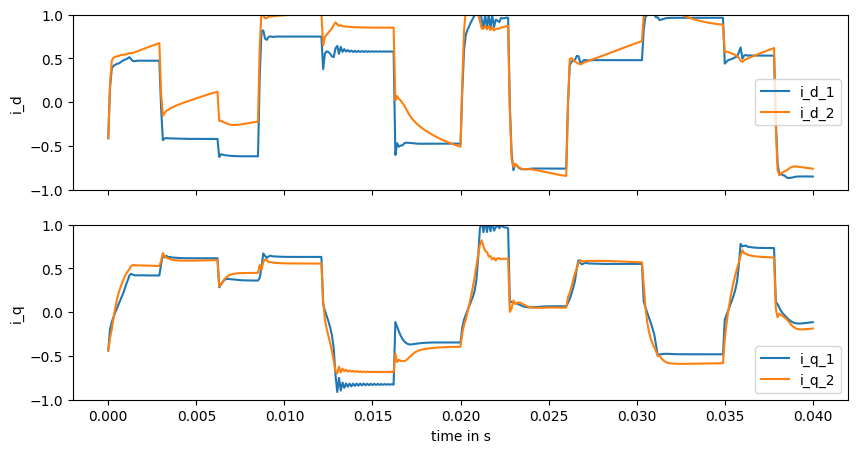

 12%|█▏        | 6000/50000 [01:40<11:01, 66.47it/s]

Current val_loss: 0.010754697


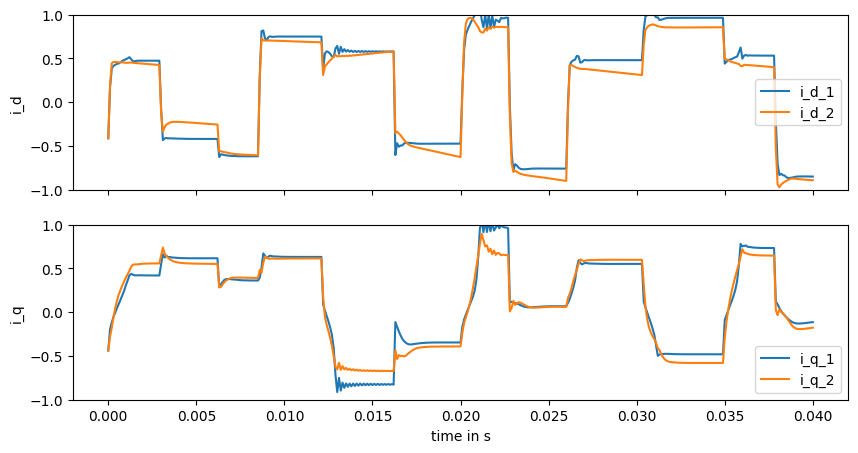

 16%|█▌        | 7995/50000 [02:11<10:25, 67.18it/s]

Current val_loss: 0.010733367


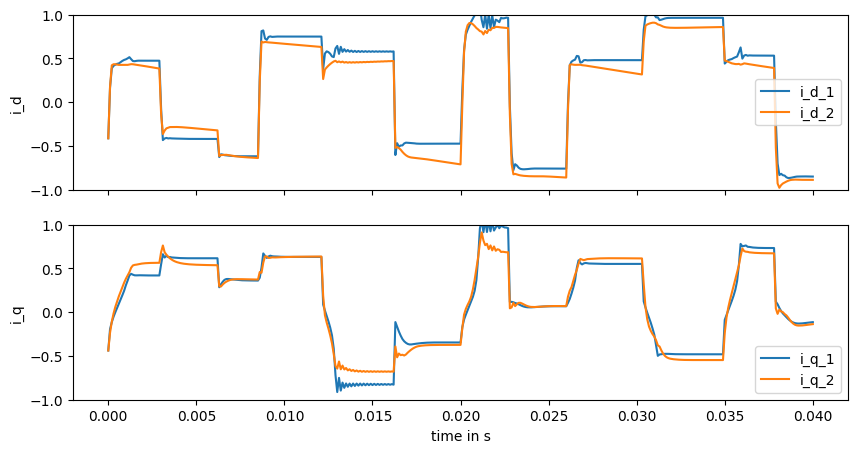

 20%|█▉        | 9997/50000 [02:41<09:57, 67.00it/s]

Current val_loss: 0.0040008137


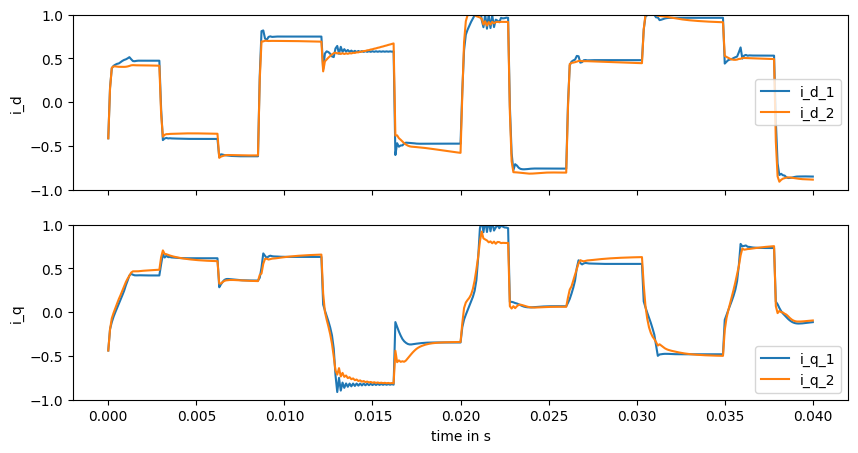

 24%|██▍       | 11999/50000 [03:12<09:28, 66.87it/s]

Current val_loss: 0.0033899937


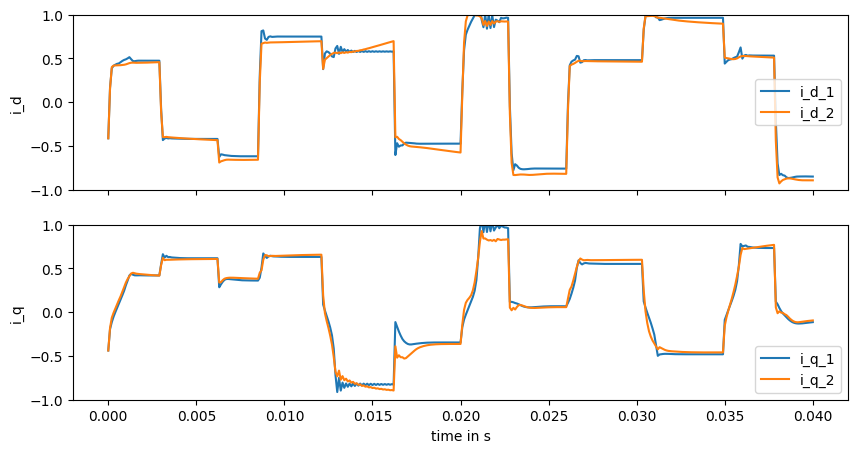

 28%|██▊       | 13994/50000 [03:42<08:57, 67.02it/s]

Current val_loss: 0.009517096


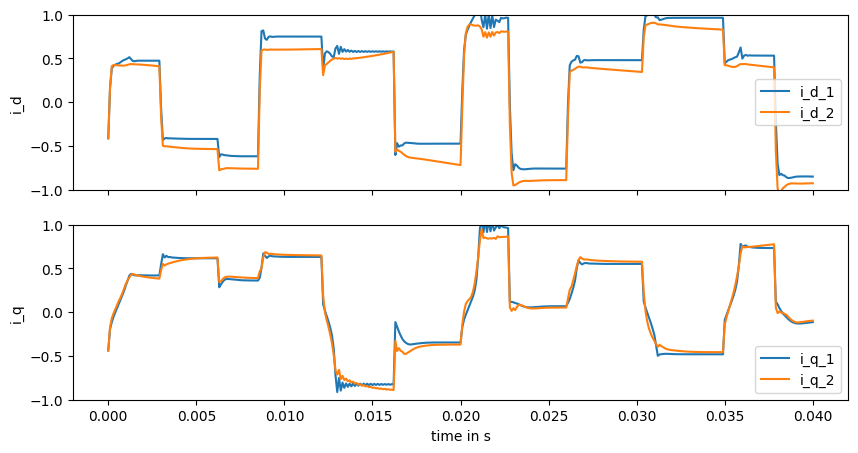

 32%|███▏      | 15996/50000 [04:13<08:28, 66.90it/s]

Current val_loss: 0.0051978594


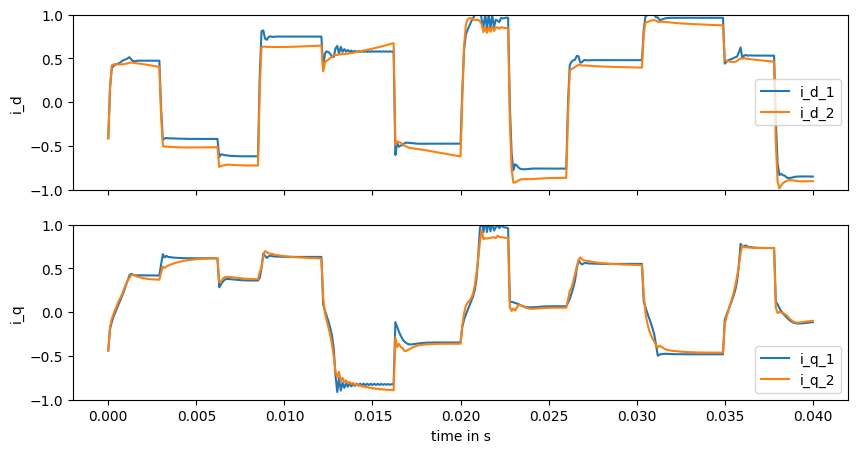

 36%|███▌      | 17998/50000 [04:44<07:59, 66.72it/s]

Current val_loss: 0.0025202332


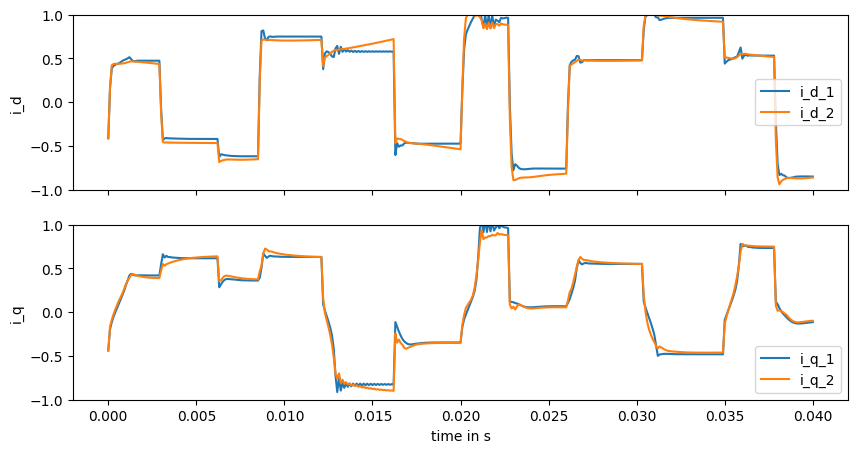

 40%|████      | 20000/50000 [05:14<07:29, 66.80it/s]

Current val_loss: 0.0025566553


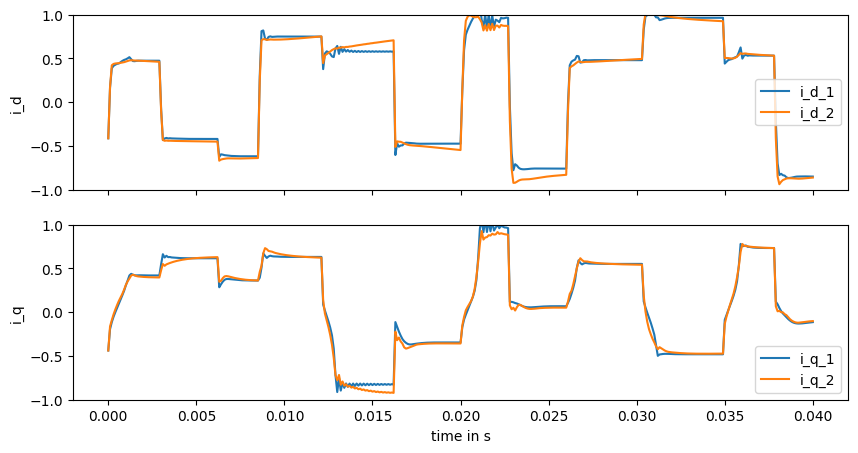

 44%|████▍     | 21995/50000 [05:44<06:58, 66.90it/s]

Current val_loss: 0.0035271093


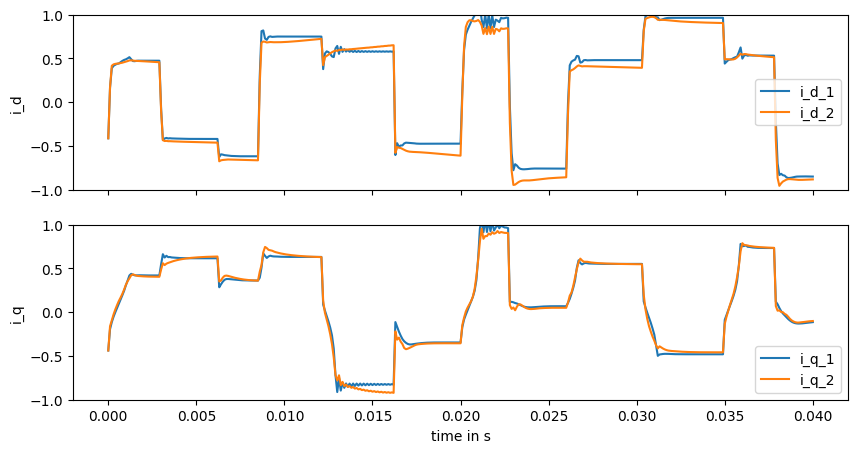

 48%|████▊     | 23997/50000 [06:15<06:29, 66.84it/s]

Current val_loss: 0.0026781715


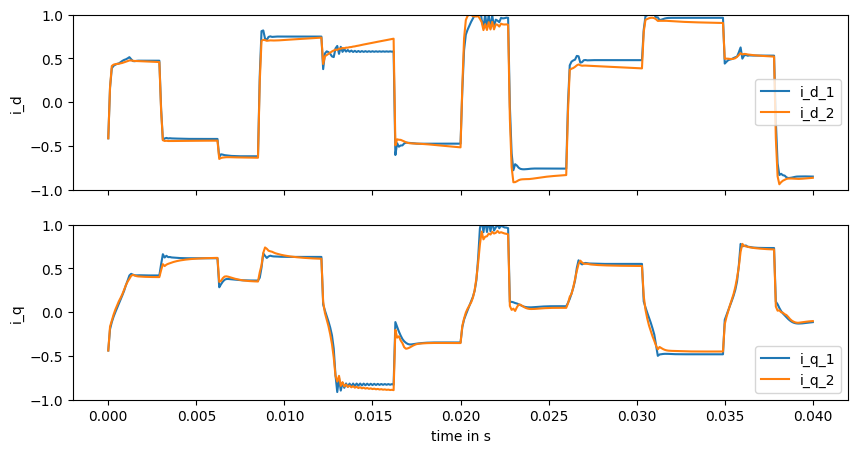

 52%|█████▏    | 25999/50000 [06:45<05:59, 66.72it/s]

Current val_loss: 0.018428916


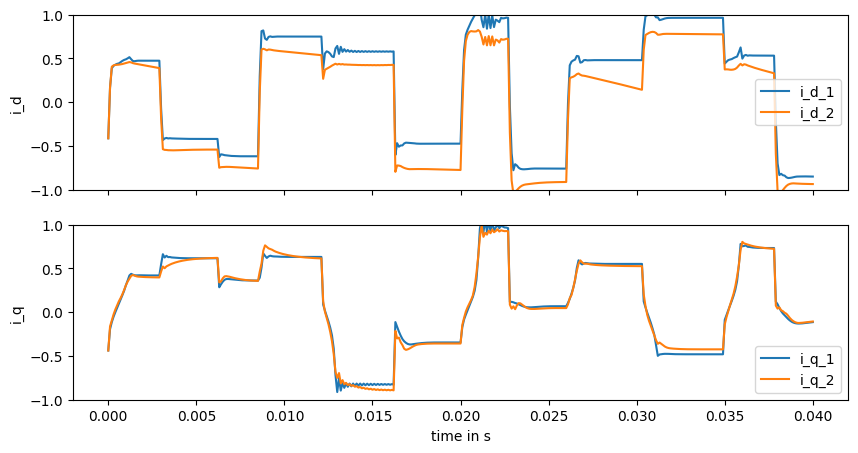

 56%|█████▌    | 28000/50000 [07:16<05:30, 66.61it/s]

Current val_loss: 0.004027367


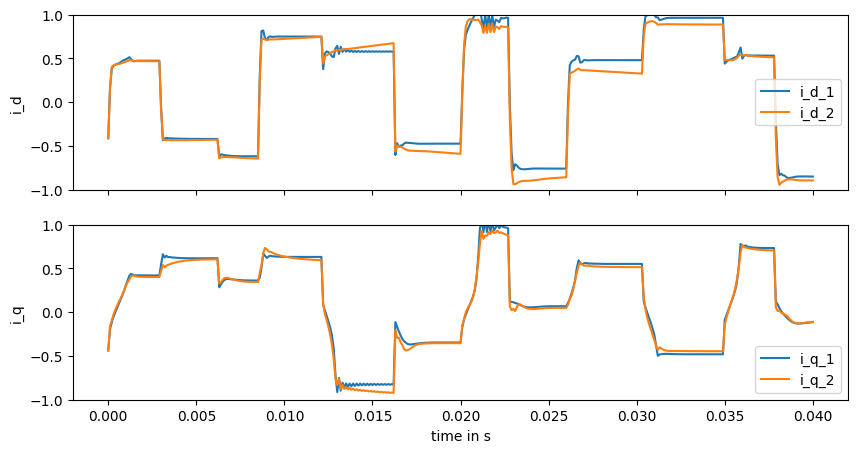

 60%|█████▉    | 29995/50000 [07:46<05:00, 66.51it/s]

Current val_loss: 0.0062282714


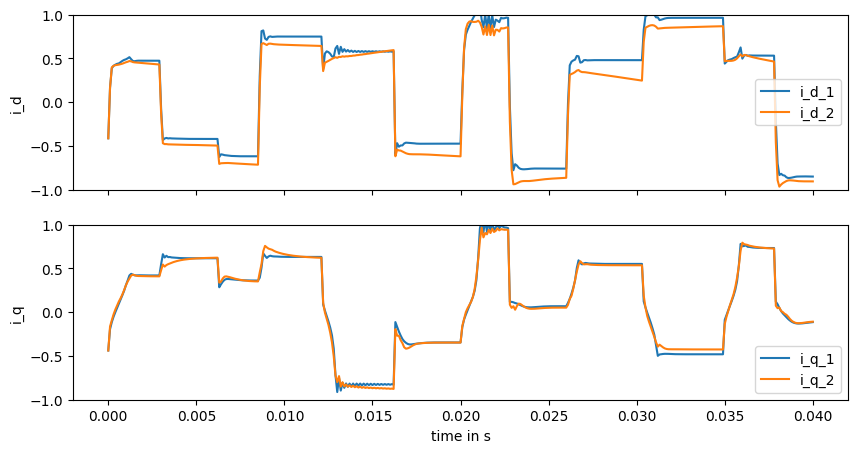

 64%|██████▍   | 31997/50000 [08:17<04:31, 66.40it/s]

Current val_loss: 0.0037546426


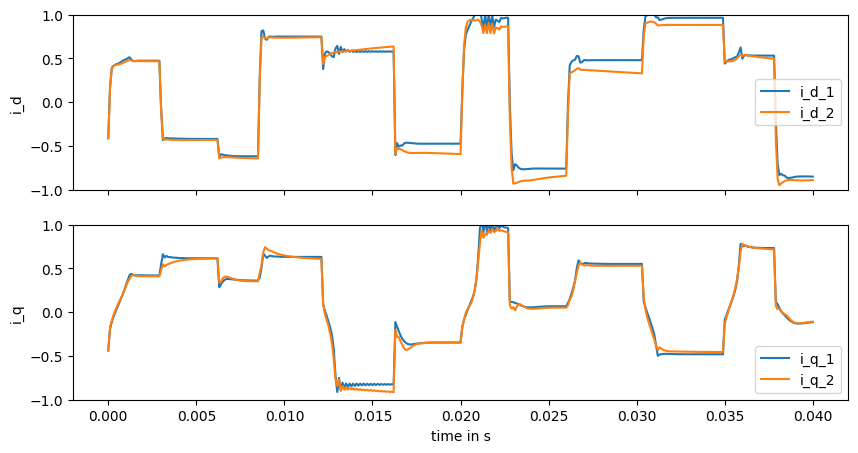

 68%|██████▊   | 33999/50000 [08:48<04:00, 66.55it/s]

Current val_loss: 0.0047982056


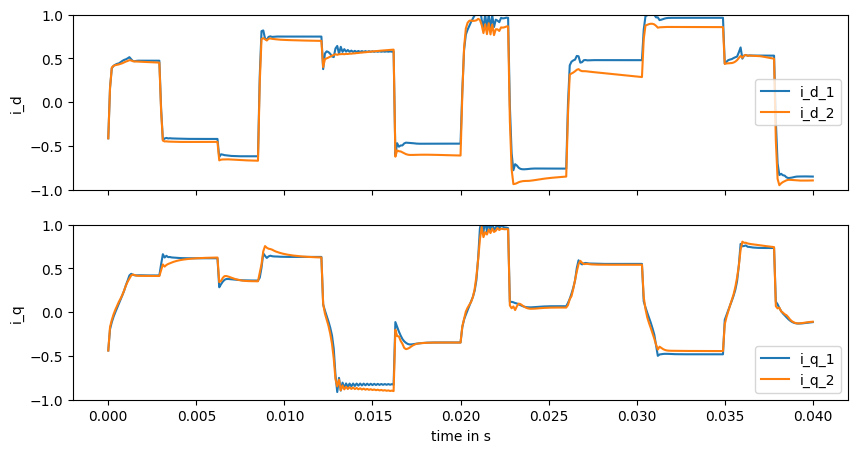

 72%|███████▏  | 35994/50000 [09:18<03:31, 66.34it/s]

Current val_loss: 0.005068684


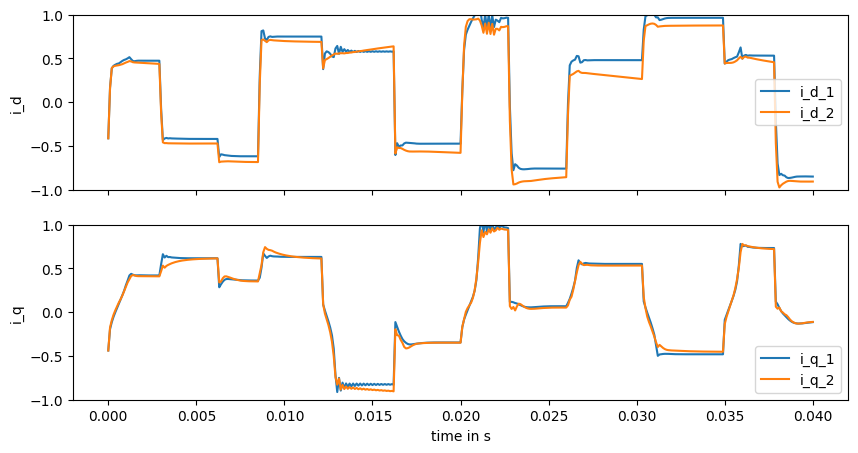

 76%|███████▌  | 37996/50000 [09:49<03:00, 66.41it/s]

Current val_loss: 0.006832025


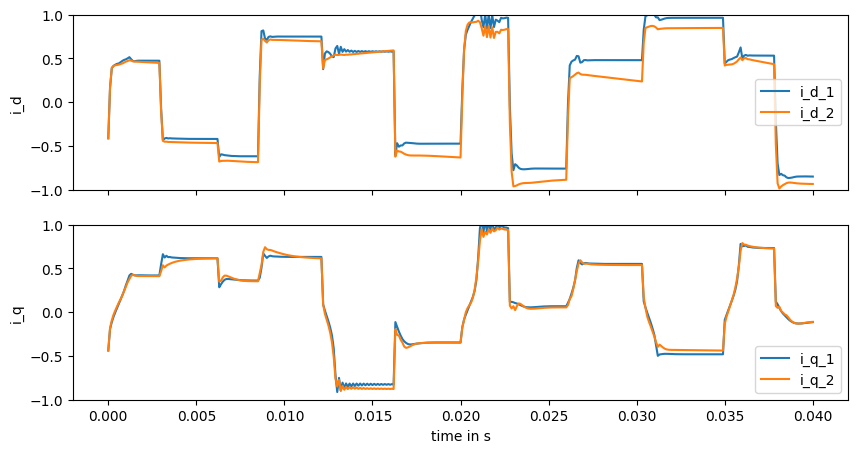

 80%|███████▉  | 39998/50000 [10:19<02:29, 66.81it/s]

Current val_loss: 0.008936211


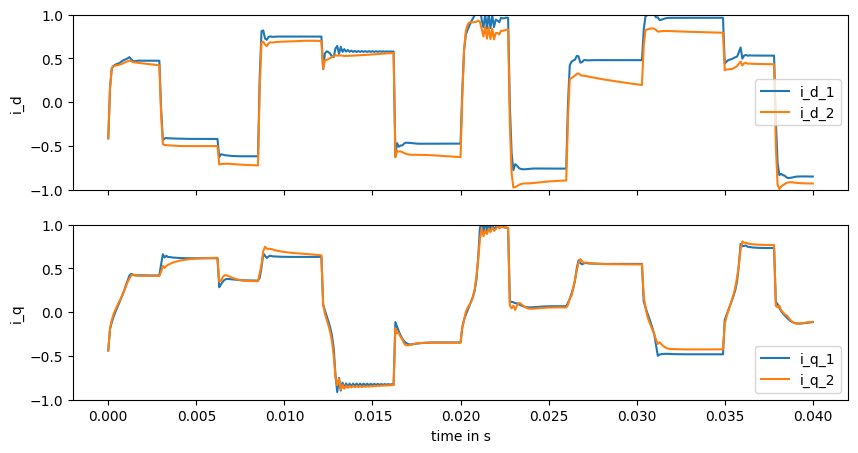

 84%|████████▍ | 42000/50000 [10:50<02:00, 66.59it/s]

Current val_loss: 0.003484484


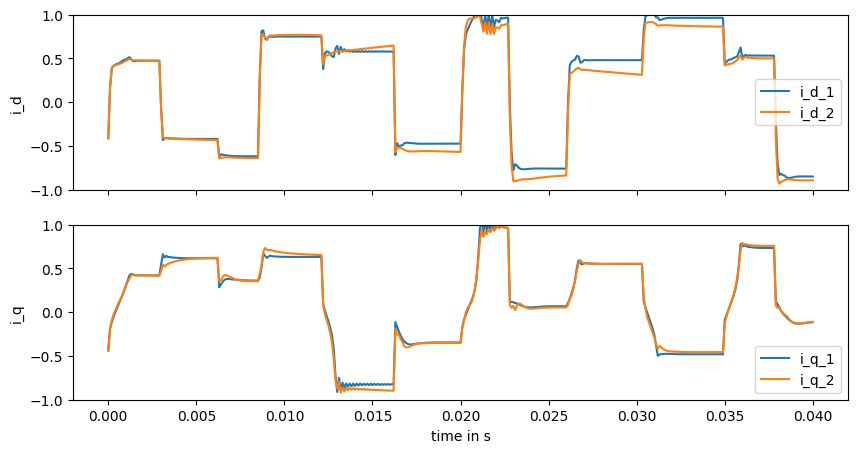

 88%|████████▊ | 43995/50000 [11:21<01:30, 66.16it/s]

Current val_loss: 0.008370852


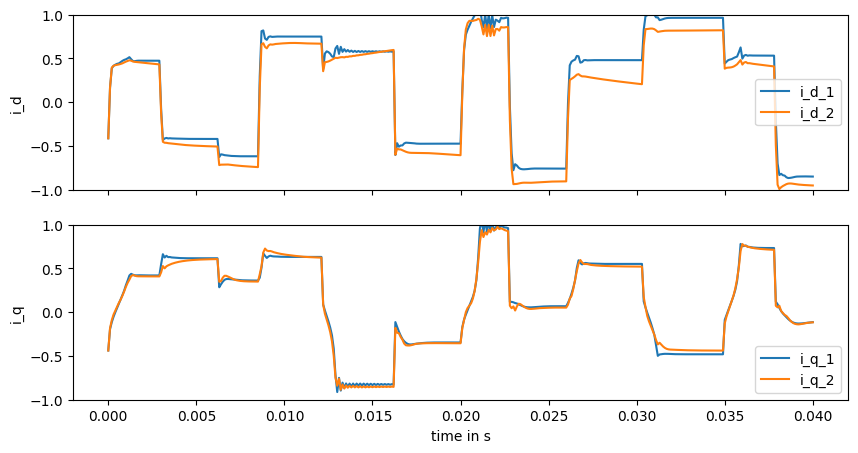

 92%|█████████▏| 45997/50000 [11:52<01:00, 66.04it/s]

Current val_loss: 0.0020676001


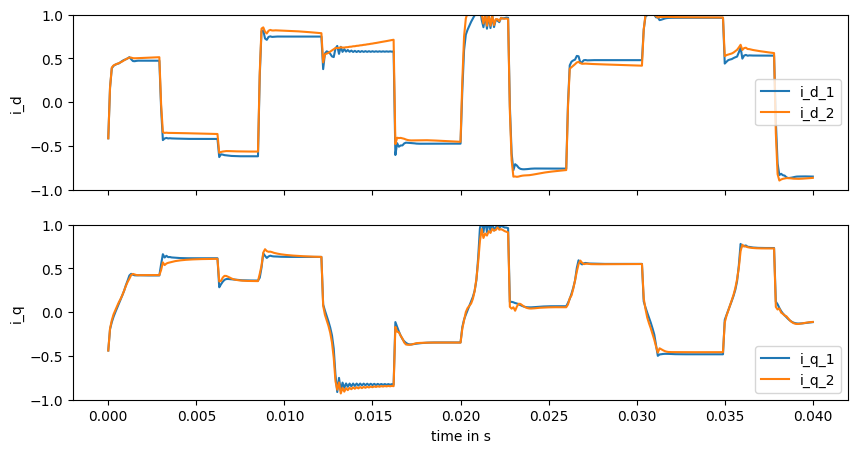

 96%|█████████▌| 47999/50000 [12:22<00:30, 66.42it/s]

Current val_loss: 0.010196535


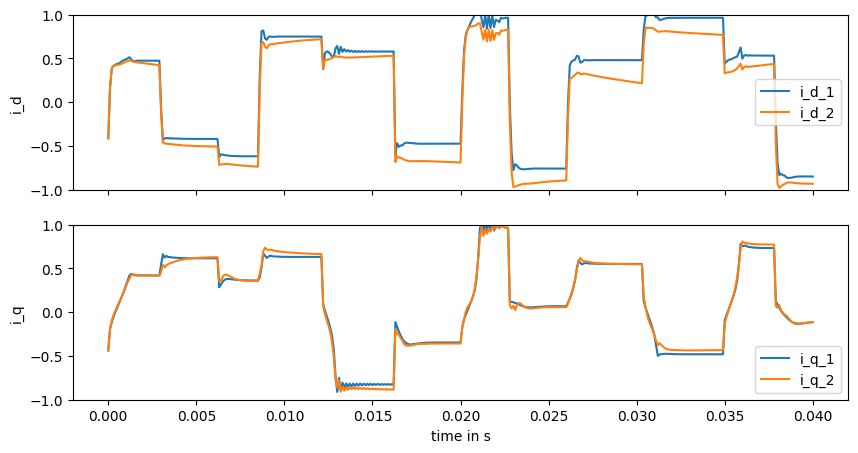

100%|██████████| 50000/50000 [12:53<00:00, 64.65it/s]


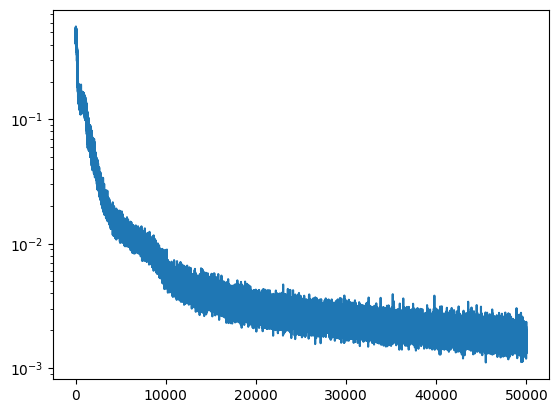

In [23]:
fin_node,fin_opt_state,fin_keys,losses, val_losses=mtrainer.fit_non_jit(node,opt_state,keys,plot_every=2000)
plt.plot(losses)
plt.yscale('log')


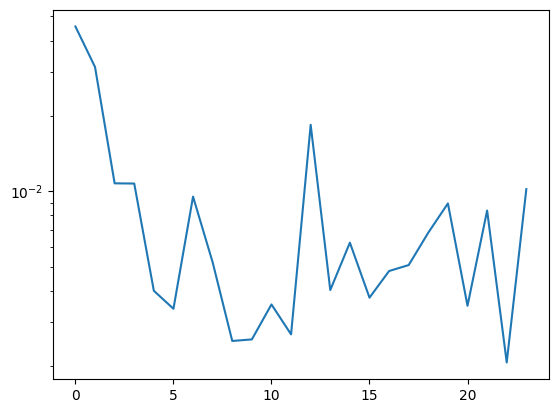

In [24]:
plt.plot(val_losses)
plt.yscale('log')

In [ ]:
#eqx.tree_serialise_leaves("trained_models/Model_150k_20len_1000b_step0_0005.eqx", fin_node)
#model_loaded = eqx.tree_deserialise_leaves("trained_models/Model1.eqx", node)

In [25]:
from utils.evaluation import steps_eval_node

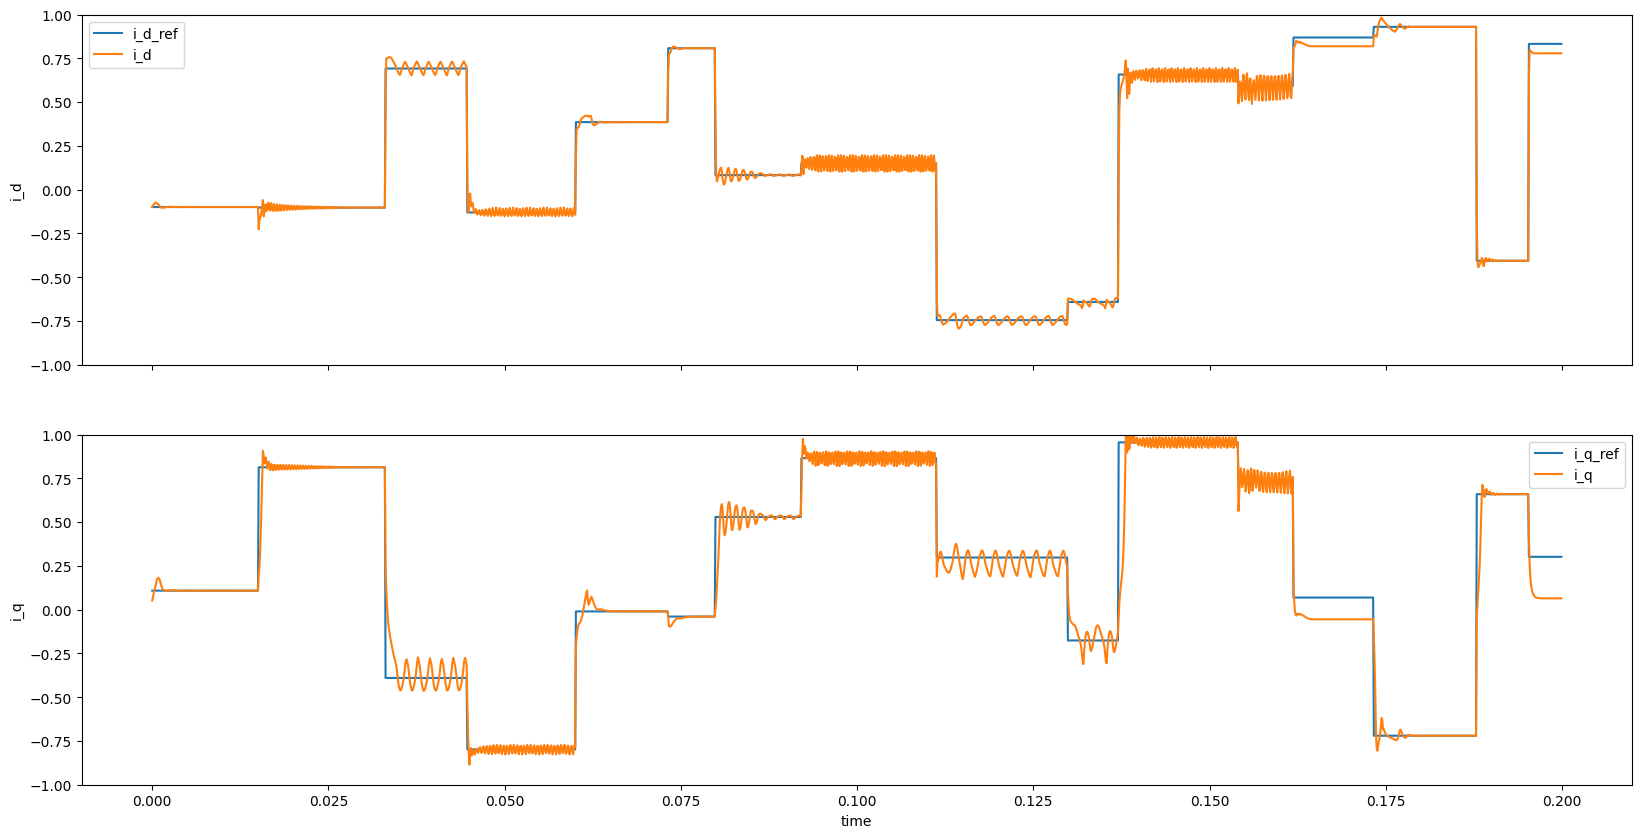

In [26]:
_,_,_=steps_eval_node(motor_env,fin_node,motor_env.tau,reset_env,fin_policy2,featurize,featurize_node,jax.random.PRNGKey(4),2000)

In [28]:
from utils.evaluation import rollout_comparison

In [39]:
model_loaded = eqx.tree_deserialise_leaves("trained_models/Model_50k_100len_100b_step0_001.eqx", node)

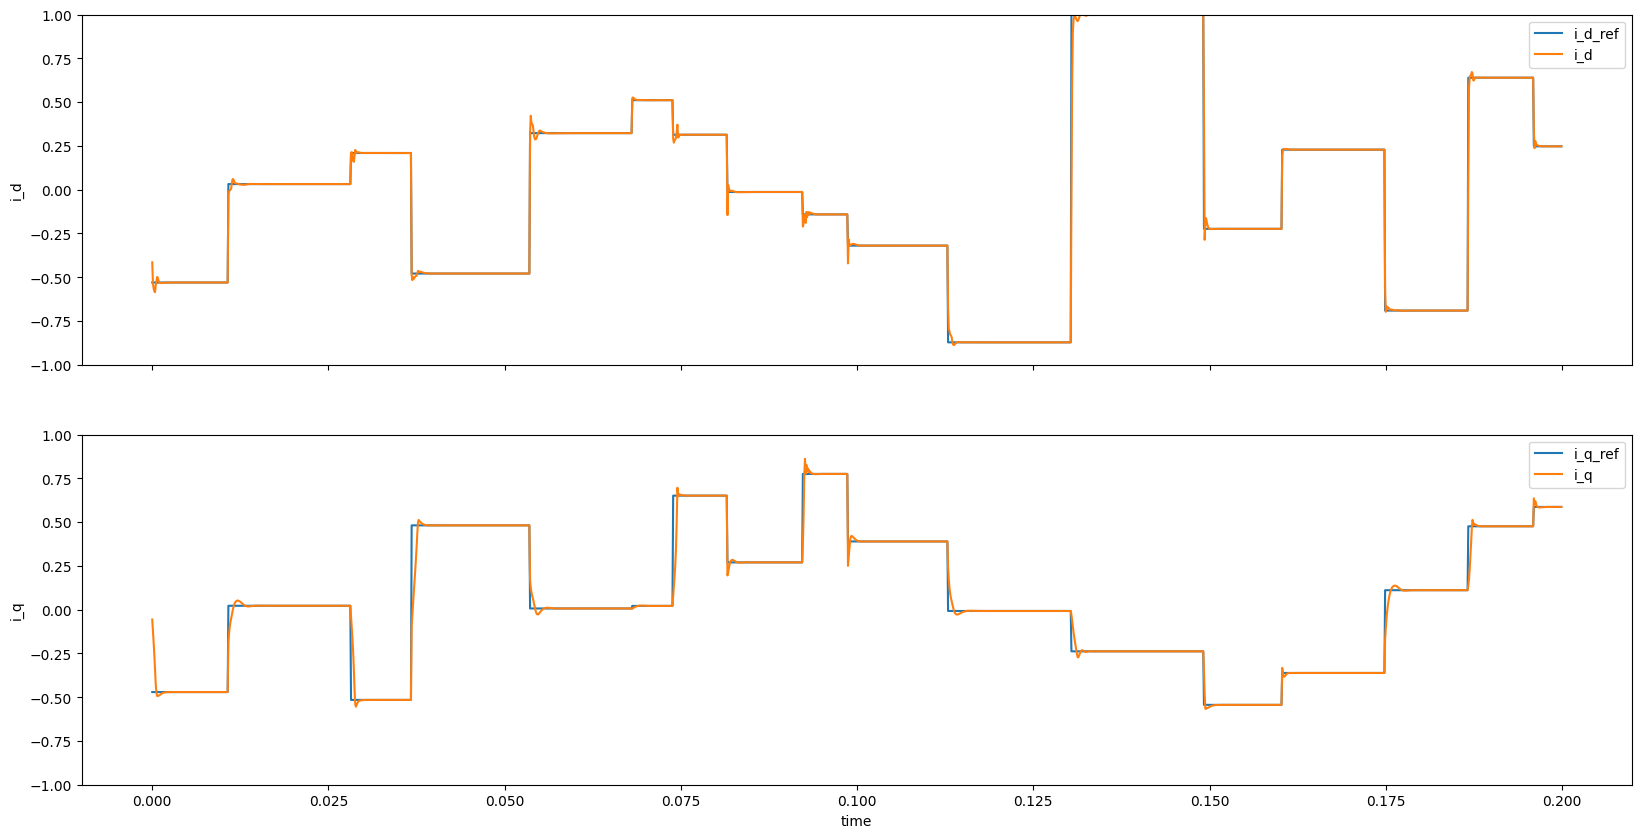

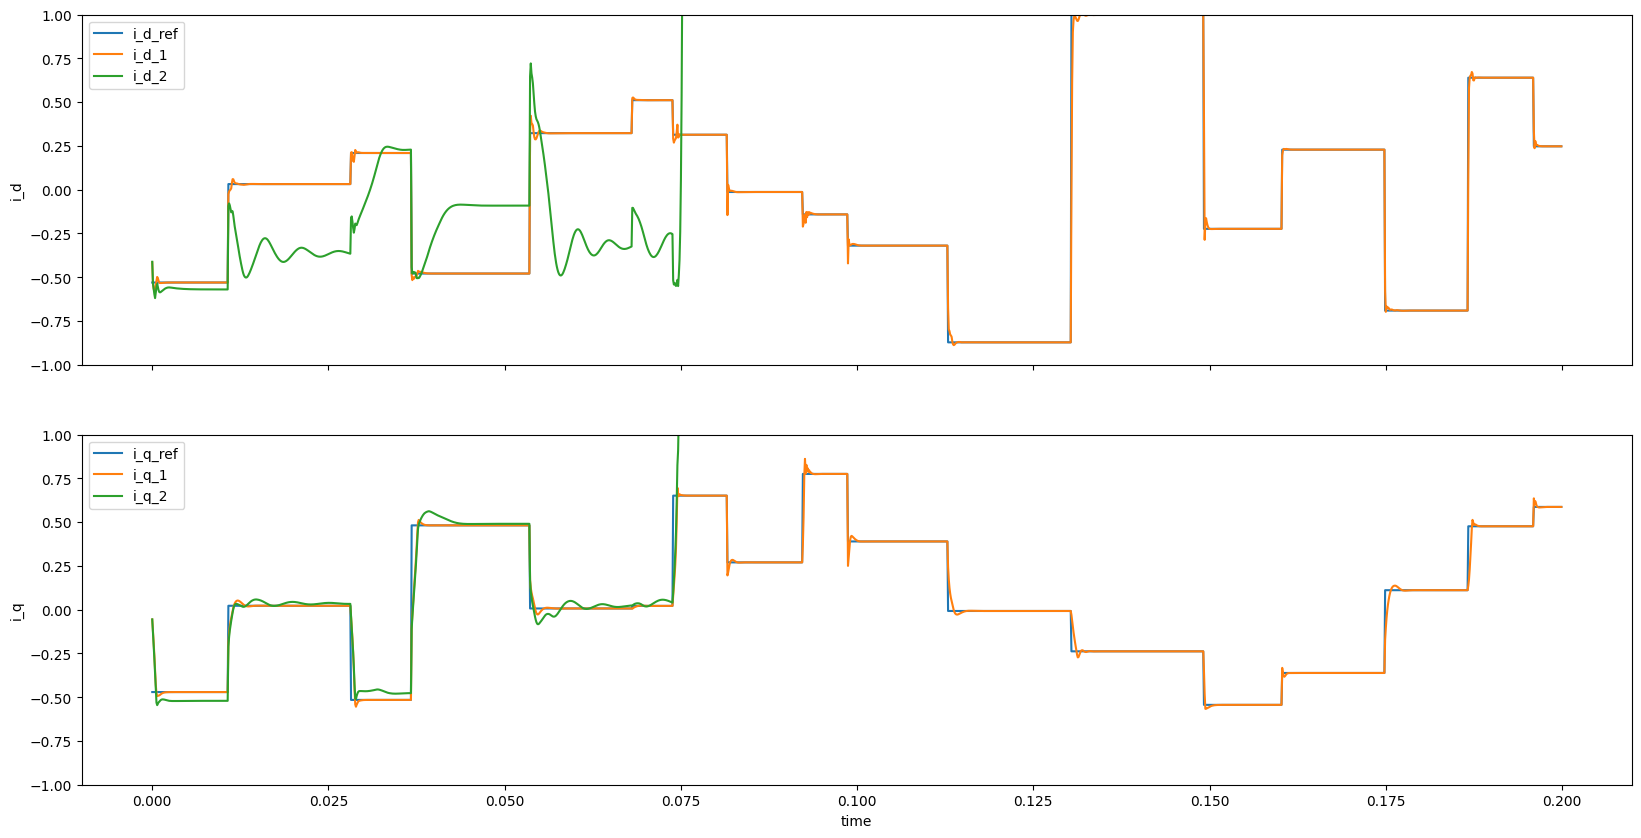

In [30]:
obs,obs_ref,acts=steps_eval(motor_env,reset_env,fin_policy2,featurize,jax.random.PRNGKey(24),2000)
obs1,obs2=rollout_comparison(motor_env,fin_node,motor_env.tau,obs[0],obs_ref,acts,featurize_node)

Note: looks like performce worse close to the constraints -> poor data coverage in contrast to middle